#  **CCAI-323 Project**

In [1]:
# Importing libraries
import numpy as np
import random
import pandas as pd

import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
import time
from sklearn import datasets

from sklearn.metrics import f1_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import rand_score

from sklearn.neighbors import NearestNeighbors
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# **1.Clustring**

## 1.1 K-means Clustering

In [2]:
class KMeans():
    '''K-Means Clustering'''
    # Initialise
    def __init__(self, k=3, max_iter=100, tol=0.0001):
        self.k= k 
        self.max_iter = max_iter
        self.tol = tol
    
    # Measure the distance (Euclidean distance) between each point and the centroid
    def euclidean(self, x1, x2):
        return np.sqrt(np.sum((x1-x2)**2))
    
    # Train model
    def fit(self, X_train):
        # Save train set for update stage
        self.X_train = X_train
        
        # Sample k points from X for initial centroids
        idx = np.random.randint(len(X_train), size=self.k)
        self.centroids = X_train[idx,:]
        self.clusters = np.zeros(len(X_train))
        
        # Iterate
        for i in range(self.max_iter):
            # Update clusters
            self.update_clusters()

            # Update centroids
            early_stop = self.update_centroids()
            
            # Early stopping if converged
            if early_stop==True:
                print(f'Early stopping occured after {i} iterations')
                break
    
    # Calculate which cluster each point belongs to
    def update_clusters(self):
        for row_idx, train_row in enumerate(self.X_train):
            dist = []
            for i in range(self.k):
                dist.append(self.euclidean(train_row, self.centroids[i]))
            self.clusters[row_idx] = np.argmin(np.array(dist))
        
    # Calculate center of each cluster (Randomly initialize n number of centroids)
    def update_centroids(self):
        # Loop over k clusters
        new_centroids = np.copy(self.centroids)
        for i in range(self.k):
            new_centroids[i] = np.mean(self.X_train[self.clusters==i], axis=0)
        
        # Check for convergence
        if np.linalg.norm(new_centroids-self.centroids)>self.tol:
            self.centroids = new_centroids
            return False
        else:
            self.centroids = new_centroids
            return True
    
    # Make predictions
    def predict(self, X_test):
        predictions = np.zeros(len(X_test))
        for row_idx, test_row in enumerate(X_test):
            dist = []
            for i in range(self.k):
                dist.append(self.euclidean(test_row, self.centroids[i]))
            predictions[row_idx] = np.argmin(np.array(dist))
        return predictions

## 1.2 DBSCAN Clustering

In [3]:
#Define a class called Point that will represent a point in 2D space
class Point(object):
    #Define initialization function for the Point class that takes a coordinate (array of two numbers) as input
    def __init__(self, coordinate):
        #Set the coordinate attribute of the Point object to the input coordinate
        self.coordinate = coordinate
         #Set the cluster_idx attribute of the Point object to None (to indicate that it has not been assigned to a cluster)
        self.cluster_idx = None
        
    #Define a function is_clustered that checks if the Point object has been assigned to a cluster    
    def is_clustered(self):
         #Return True if the cluster_idx attribute of the Point object is not None, otherwise return False
        return self.cluster_idx is not None
    
    #Define a function cluster that assigns the Point object to a cluster
    def cluster(self, cluster_idx):
        #Set the cluster_idx attribute of the Point object to the input cluster_idx
        self.cluster_idx = cluster_idx

#Define class called DBSCAN that will implement the Density Based Spatial Clustering of Applications with Noise algorithm
class DBSCAN(object):
    
    #Define an initialization function for the DBSCAN class that takes two parameters: epsi (a distance threshold) and min_points (the minimum number of points required to form a cluster)
    def __init__(self, epsi, min_points):
        #Set the epsilon attribute of the DBSCAN object to the input epsilon
        self.epsi = epsi
        #Set the min_points attribute of the DBSCAN object to the input min_points
        self.min_points = min_points
    
    @staticmethod
    #Define a static method _compute_distance that calculates the Euclidean distance between two points
    def _compute_distance(x1, x2):
        #Return the square root of the sum of the squared differences between the coordinates of the two points (using numpy)
        return np.sum((x1 - x2)**2)**0.5

    #Define a method _find_neighbor_indices that finds the indices of points that are within the distance threshold of a core point
    def _find_neighbor_indices(self, core_point, other_points):
        #Create an empty list to store the indices of the neighboring points
        neighbor_indices = []
        
        #Loop through all the other points in the dataset
        for idx in range(len(other_points)):
            #If the distance between the core point and the other point is less than or equal to the distance threshold
            if self._compute_distance(core_point.coordinate, other_points[idx].coordinate) <= self.epsi:
                neighbor_indices.append(idx)
        #Return the list of neighboring indices        
        return neighbor_indices
    #Define a method fit that clusters the points in a dataset using the DBSCAN algorithm
    def fit(self, df, feature_cols=['X', 'y']):
        #Create an empty list to store the Point objects
        points = []
        #Loop through each row in the dataset (using the specified feature columns)
        for idx, row in df.loc[:, feature_cols].iterrows():
            #Create a new Point object with the row's coordinates and add it to the list of points
            points.append(Point(row.to_numpy()))
        #Create a set of indices for the points that have not been assigned to a cluster             
        free_point_indices = set(range(len(points)))
        #Create a set of indices for the core points that have been assigned to
        core_point_indices = set()
        #initialize the cluster count to 0
        cluster_count = 0
        
        #loop until all points are assigned to a cluster
        while len(free_point_indices) > 0:
            #if no core points have been found yet
            if len(core_point_indices) == 0:
                #randomly pick a point to start a new cluster
                start_idx = random.choice(list(free_point_indices))
                #add the index of the starting point to the set of core point indices
                core_point_indices.add(start_idx)
                #remove the starting point from the set of free point indices
                free_point_indices.remove(start_idx)
                 #assign the starting point to the current cluster
                points[start_idx].cluster(cluster_count)
            
            # while there are still core points in the set
            while len(core_point_indices) > 0:
                 #remove a core point index from the set of core point indices
                picked_core_point_idx = core_point_indices.pop()
                 #find the indices of all neighboring points to the core point
                neighbor_indices = self._find_neighbor_indices(points[picked_core_point_idx], points)
                
                #if the number of neighbors is greater than or equal to the minimum number of points required to form a cluster
                if len(neighbor_indices) >= (self.min_points - 1):
                    #loop over all neighboring point indices
                    for neighbor_idx in neighbor_indices:
                        #if the neighbor has not been assigned to a cluster
                        if neighbor_idx in free_point_indices:
                            # assign the neighbor to the current cluster
                            points[neighbor_idx].cluster(cluster_count)
                            #if the neighbor is still in the set of free point indices
                            if neighbor_idx in free_point_indices:
                                #add the neighbor index to the set of core point indices
                                core_point_indices.add(neighbor_idx)
                                #remove the neighbor index from the set of free point indices
                                free_point_indices.remove(neighbor_idx)
             #increment the cluster count after all core points for the current cluster have been found       
            cluster_count += 1
        #return the list of points with their assigned clusters     
        return points

# **2.Generate dataset1**

In [4]:
n_samples = 300
random_state = 61

X,y =  datasets.make_blobs(n_samples=n_samples,random_state=random_state)

data1 = pd.DataFrame(data=X, columns=['X', 'y'])
data1.head()

,X,y
0,6.624160,-5.479649
1,7.493721,1.028567
2,6.788384,-6.059096
3,9.294954,-9.573425
4,10.505947,-9.042722


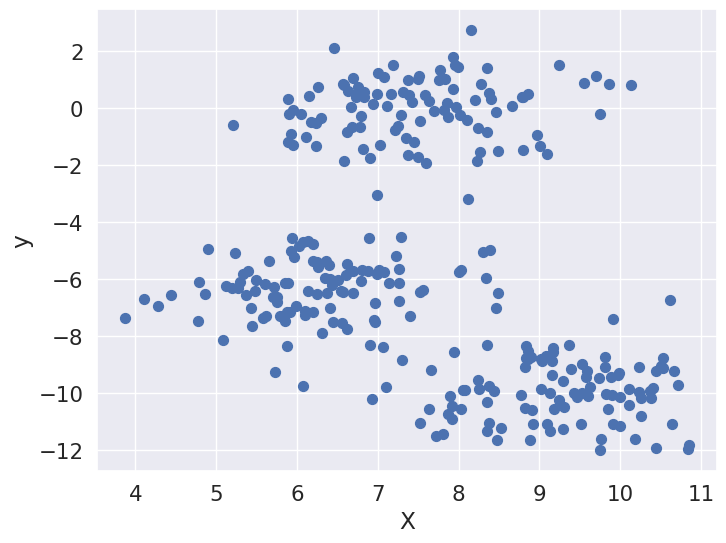

In [5]:
# Plot dataset1
plt.figure(figsize=(8,6))
plt.scatter(data1['X'],data1['y'],s=50)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# **3.Apply created models on dataset1 and compare the results**

>## 1.1 K-means Clustering

In [6]:
# Apply our k-Means algorithm
model_data1 = KMeans(k=3, max_iter=30)
model_data1.fit(data1.values)
y_pred1 = model_data1.predict(data1.values)
y_true1 = y

Early stopping occured after 3 iterations


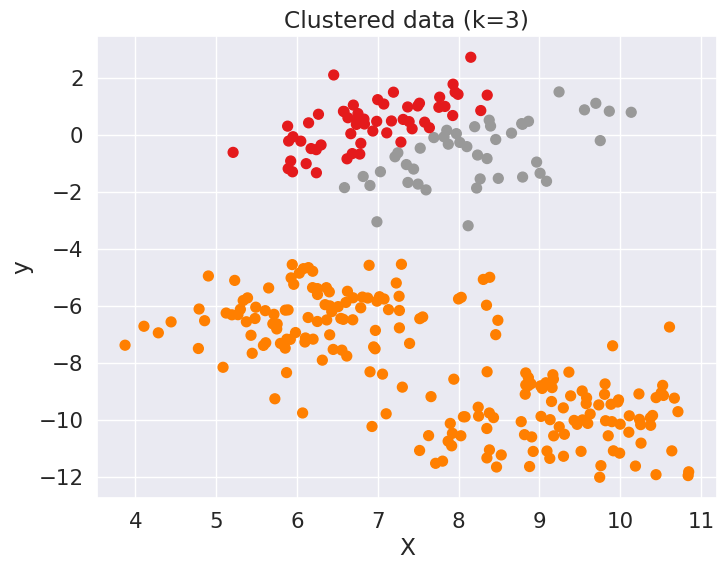

In [7]:
# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(data1['X'],data1['y'],c=y_pred1,cmap='Set1',s=50)
plt.title('Clustered data (k=3)')
plt.xlabel("X")
plt.ylabel("y")
plt.show()

>## 1.2 DBSCAN Clustering

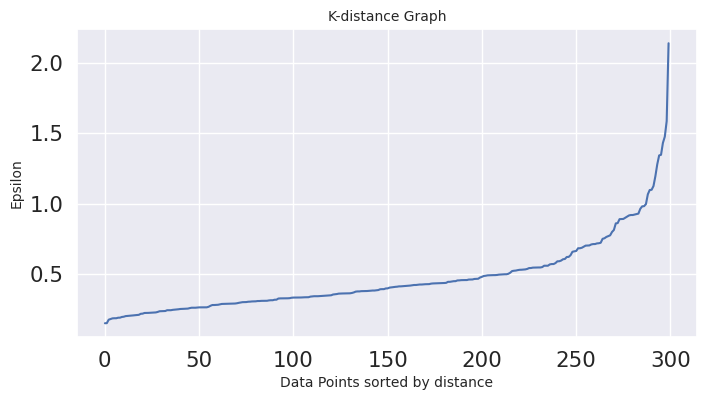

In [8]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(data1[['X','y']])
distances, indices = nbrs.kneighbors(data1[['X','y']])

distances = np.sort(distances, axis=0)
distances = distances[:,4]
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Data Points sorted by distance',fontsize=10)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

In [9]:
EPSI = 1
MIN_POINTS = 4

model = DBSCAN(epsi=EPSI, min_points=MIN_POINTS)

points = model.fit(data1)

In [10]:
x = []
y = []
cluster = []

for point in points:
    _x, _y = point.coordinate
    x.append(_x)
    y.append(_y)
    cluster.append(point.cluster_idx)

In [11]:
new_data1 = pd.DataFrame({'X': x,'y': y,'cluster': cluster})
new_data1

,X,y,cluster
0,6.624160,-5.479649,1
1,7.493721,1.028567,0
2,6.788384,-6.059096,1
3,9.294954,-9.573425,1
4,10.505947,-9.042722,1
...,...,...,...
295,9.968172,-9.367592,1
296,8.903558,-10.593546,1
297,7.267099,-6.763872,1
298,6.113543,-0.997387,0


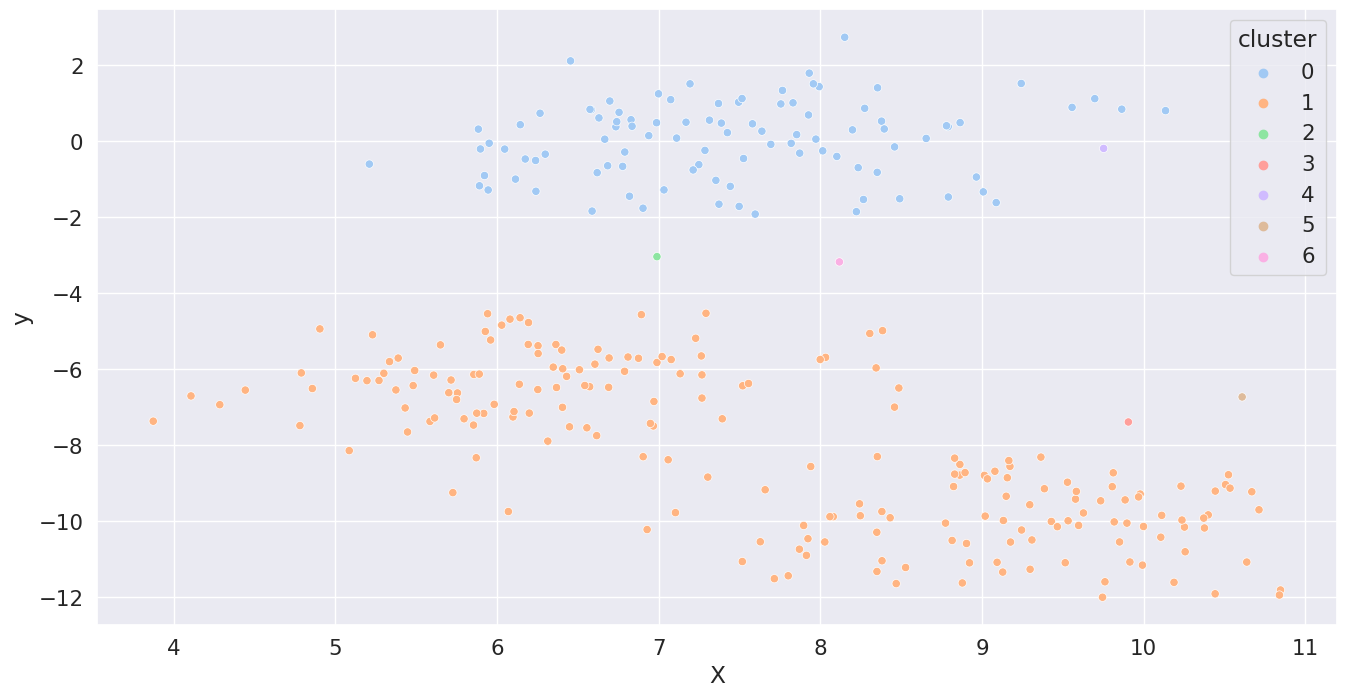

In [12]:
y_pred1_DBSCAN = new_data1['cluster']
fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(data=new_data1, x='X', y='y', hue='cluster', palette='pastel', ax=ax)
plt.show()

# **4.Generate dataset2**

In [13]:
X, y = datasets.make_blobs(n_samples=n_samples,random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)

data2 = pd.DataFrame(data=X, columns=['X', 'y'])
data2.head()

,X,y
0,6.166356,-8.358216
1,4.084805,-3.673378
2,6.496669,-8.920308
3,9.406343,-13.235713
4,9.920657,-13.537746


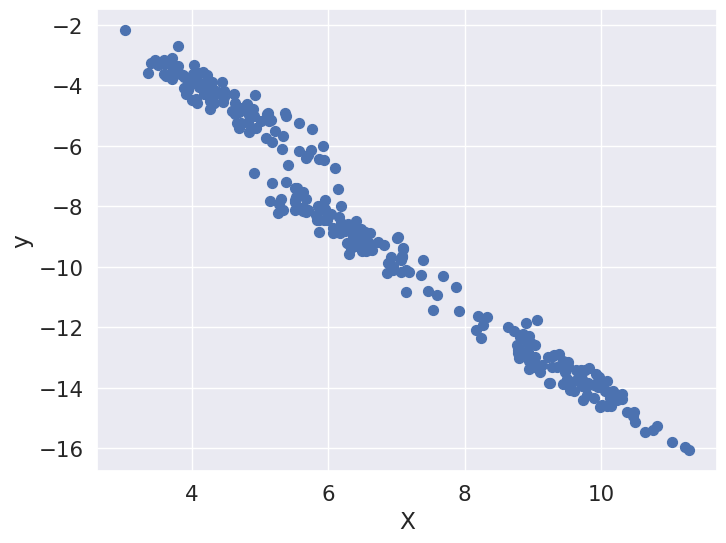

In [14]:
# Plot dataset2
plt.figure(figsize=(8,6))
plt.scatter(data2['X'],data2['y'],s=50)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# **5.Apply created models on dataset2 and compare the results**

> ## 1.1 K-means Clustering

In [15]:
# Apply our k-Means algorithm
model_data2 = KMeans(k=3, max_iter=30)
model_data2.fit(data2.values)
y_pred2 = model_data2.predict(data2.values)
y_true2 = y

Early stopping occured after 5 iterations


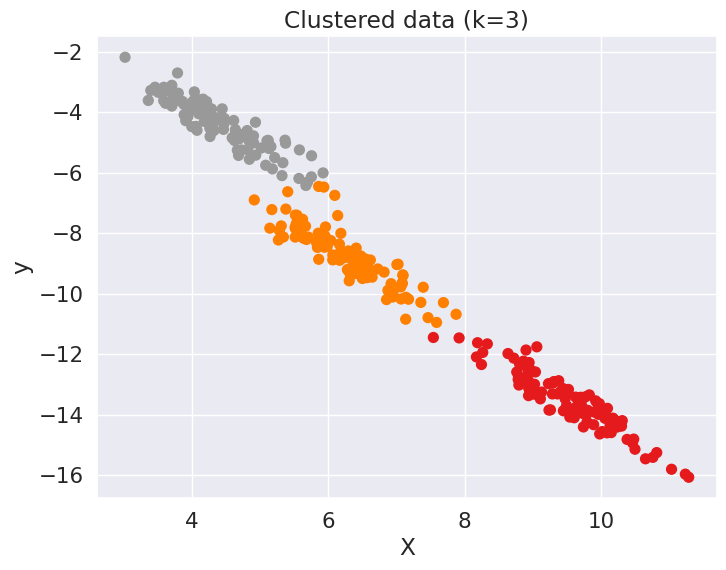

In [16]:
# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(data2['X'],data2['y'],c=y_pred2,cmap='Set1',s=50)
plt.title('Clustered data (k=3)')
plt.xlabel("X")
plt.ylabel("y")
plt.show()

>## 1.2 DBSCAN Clustering

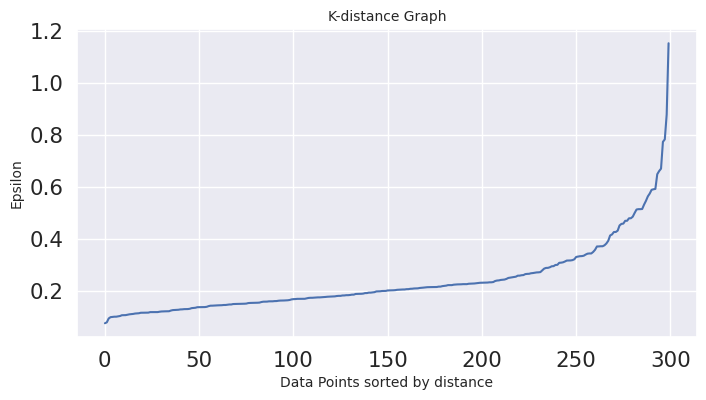

In [17]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(data2[['X','y']])
distances, indices = nbrs.kneighbors(data2[['X','y']])

distances = np.sort(distances, axis=0)
distances = distances[:,4]
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Data Points sorted by distance',fontsize=10)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

In [18]:
EPSI = 0.5
MIN_POINTS = 4

model = DBSCAN(epsi=EPSI, min_points=MIN_POINTS)

points = model.fit(data2)

In [19]:
x = []
y = []
cluster = []

for point in points:
    _x, _y = point.coordinate
    x.append(_x)
    y.append(_y)
    cluster.append(point.cluster_idx)

In [20]:
new_data2 = pd.DataFrame({'X': x,'y': y,'cluster': cluster})
new_data2

,X,y,cluster
0,6.166356,-8.358216,1
1,4.084805,-3.673378,2
2,6.496669,-8.920308,1
3,9.406343,-13.235713,0
4,9.920657,-13.537746,0
...,...,...,...
295,9.727940,-13.474977,0
296,9.579553,-13.816972,0
297,7.065809,-9.771358,1
298,4.067081,-4.466036,2


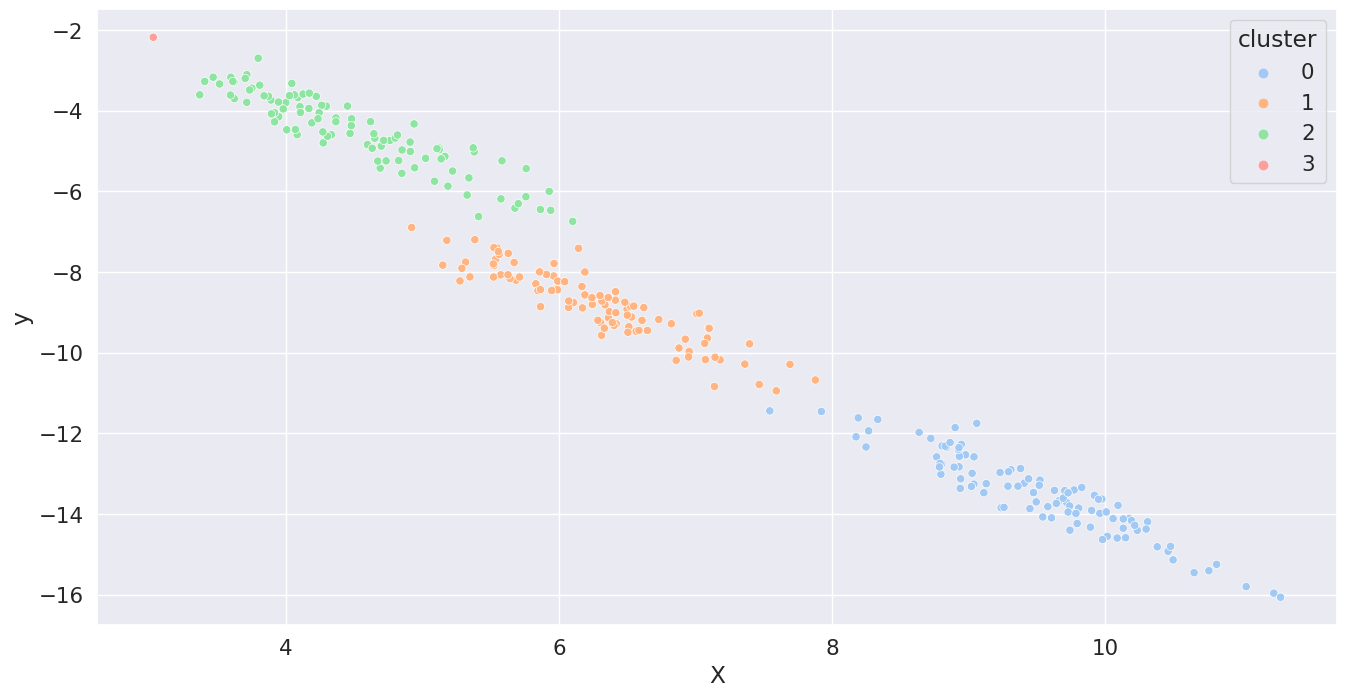

In [21]:
y_pred2_DBSCAN = new_data2['cluster']

fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(data=new_data2, x='X', y='y', hue='cluster', palette='pastel', ax=ax)
plt.show()

# **6.Generate dataset3**

In [22]:
X, y = datasets.make_moons(n_samples=n_samples, noise=0.1,random_state=random_state)

data3 = pd.DataFrame(data=X, columns=['X', 'y'])
data3.head()

,X,y
0,1.168941,-0.546863
1,0.164265,-0.183249
2,0.424344,0.876935
3,0.010975,0.849364
4,0.704108,-0.474524


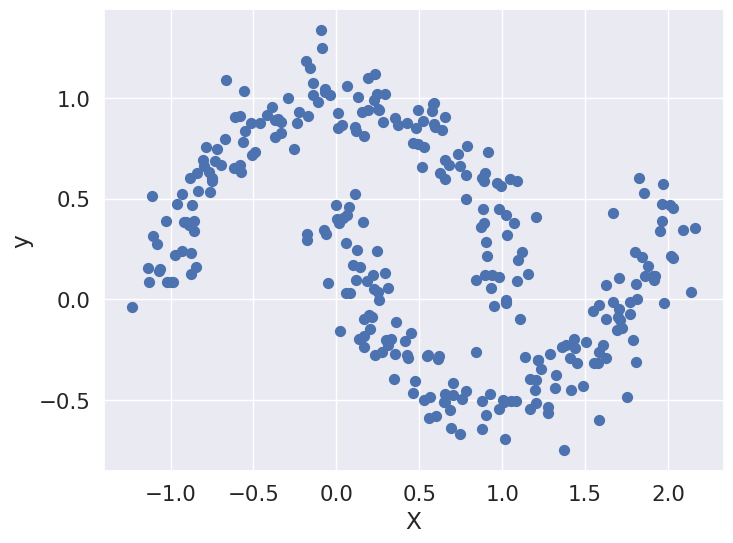

In [23]:
# Plot dataset3
plt.figure(figsize=(8,6))
plt.scatter(data3['X'],data3['y'],s=50)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# **7.Apply created models on dataset3 and compare the results**

> ## 1.1 K-means Clustering

In [24]:
# Apply our k-Means algorithm
model_data3 = KMeans(k=2, max_iter=30)
model_data3.fit(data3.values)
y_pred3 = model_data3.predict(data3.values)
y_true3 = y

Early stopping occured after 7 iterations


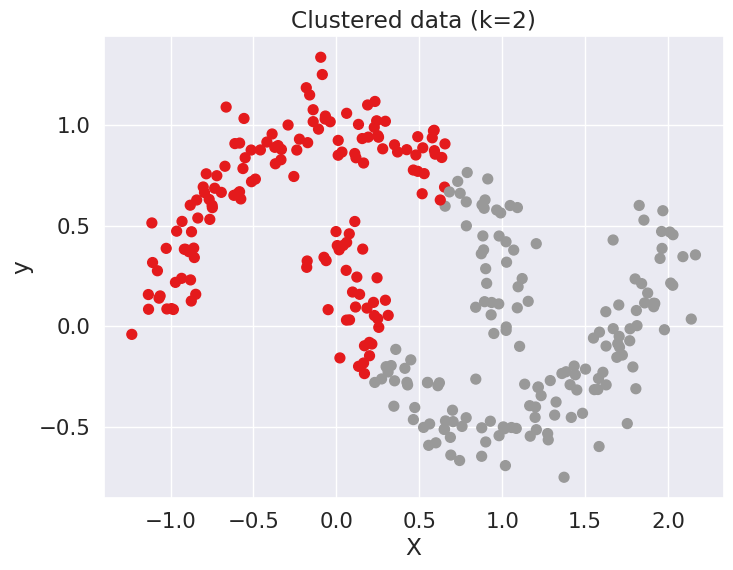

In [25]:
# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(data3['X'],data3['y'],c=y_pred3,cmap='Set1',s=50)
plt.title('Clustered data (k=2)')
plt.xlabel("X")
plt.ylabel("y")
plt.show()

>## 1.2 DBSCAN Clustering

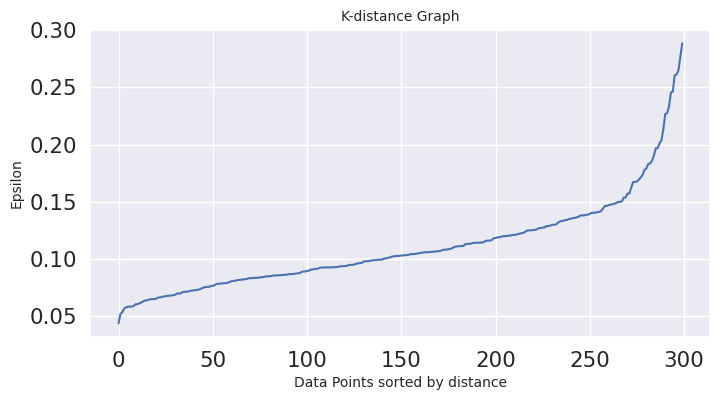

In [26]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(data3[['X','y']])
distances, indices = nbrs.kneighbors(data3[['X','y']])

distances = np.sort(distances, axis=0)
distances = distances[:,4]
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Data Points sorted by distance',fontsize=10)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

In [27]:
EPSI = 0.15
MIN_POINTS = 4

model = DBSCAN(epsi=EPSI, min_points=MIN_POINTS)

points = model.fit(data3)

In [28]:
x = []
y = []
cluster = []

for point in points:
    _x, _y = point.coordinate
    x.append(_x)
    y.append(_y)
    cluster.append(point.cluster_idx)

In [29]:
new_data3 = pd.DataFrame({'X': x,'y': y,'cluster': cluster})
new_data3

,X,y,cluster
0,1.168941,-0.546863,0
1,0.164265,-0.183249,0
2,0.424344,0.876935,1
3,0.010975,0.849364,1
4,0.704108,-0.474524,0
...,...,...,...
295,0.626557,0.626944,1
296,0.295722,0.128726,0
297,1.022981,0.419264,1
298,0.783362,0.617523,1


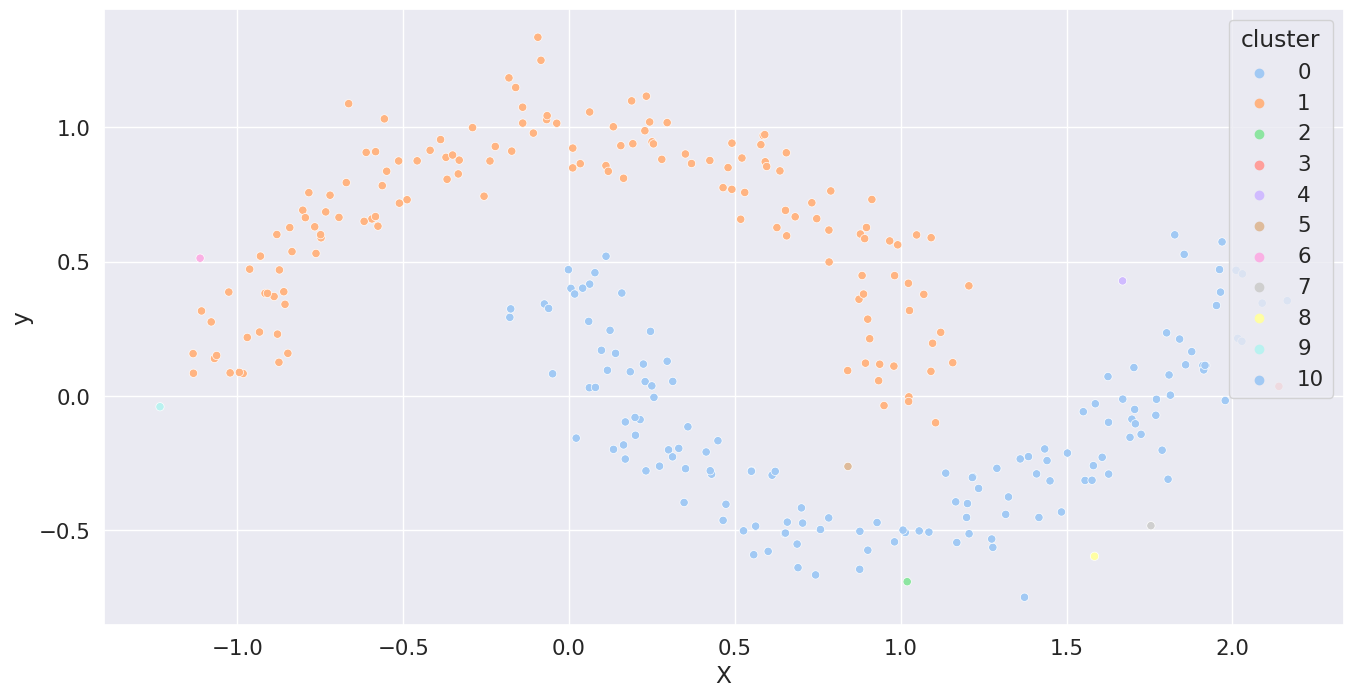

In [30]:
y_pred3_DBSCAN = new_data3['cluster']

fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(data=new_data3, x='X', y='y', hue='cluster', palette='pastel', ax=ax)
plt.show()

# **8.Generate dataset4**

In [31]:
X,y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05,random_state=random_state)

data4 = pd.DataFrame(data=X, columns=['X', 'y'])
data4.head()

,X,y
0,-0.455897,-0.109065
1,0.113536,0.443989
2,-0.656790,0.723281
3,-1.017373,0.092811
4,-0.445370,0.254486


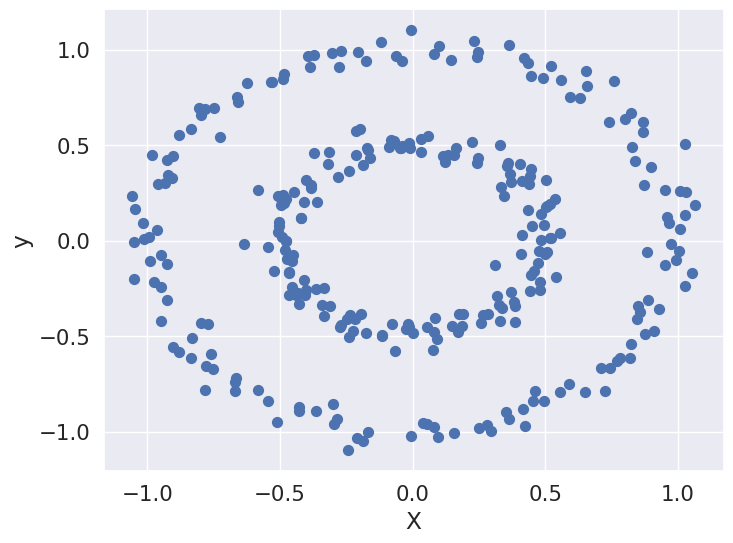

In [32]:
# Plot dataset4
plt.figure(figsize=(8,6))
plt.scatter(data4['X'],data4['y'],s=50)
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# **9.Apply created models on dataset4 and compare the results**

> ## 1.1 K-means Clustering

In [33]:
# Apply our k-Means algorithm
model_data4 = KMeans(k=2, max_iter=30)
model_data4.fit(data4.values)
y_pred4 = model_data4.predict(data4.values)
y_true4 = y

Early stopping occured after 3 iterations


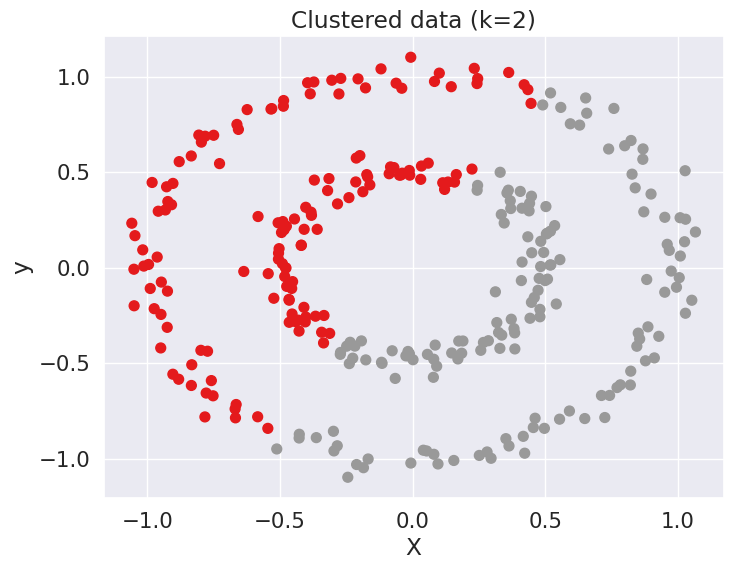

In [34]:
# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(data4['X'],data4['y'],c=y_pred4,cmap='Set1',s=50)
plt.title('Clustered data (k=2)')
plt.xlabel("X")
plt.ylabel("y")
plt.show()

>## 1.2 DBSCAN Clustering

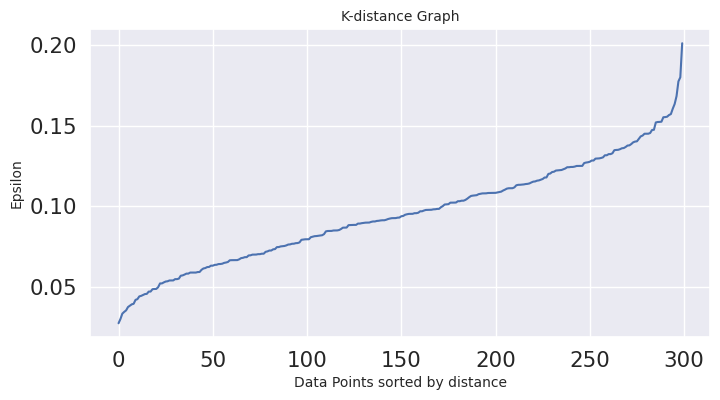

In [35]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(data4[['X','y']])
distances, indices = nbrs.kneighbors(data4[['X','y']])

distances = np.sort(distances, axis=0)
distances = distances[:,4]
plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=10)
plt.xlabel('Data Points sorted by distance',fontsize=10)
plt.ylabel('Epsilon',fontsize=10)
plt.show()

In [36]:
EPSI = 0.18
MIN_POINTS = 4

model = DBSCAN(epsi=EPSI, min_points=MIN_POINTS)

points = model.fit(data4)

In [37]:
x = []
y = []
cluster = []

for point in points:
    _x, _y = point.coordinate
    x.append(_x)
    y.append(_y)
    cluster.append(point.cluster_idx)

In [38]:
new_data4 = pd.DataFrame({'X': x,'y': y,'cluster': cluster})
new_data4

,X,y,cluster
0,-0.455897,-0.109065,1
1,0.113536,0.443989,1
2,-0.656790,0.723281,0
3,-1.017373,0.092811,0
4,-0.445370,0.254486,1
...,...,...,...
295,0.082430,0.974229,0
296,0.329992,0.498896,1
297,0.823367,0.665285,0
298,0.656228,0.808071,0


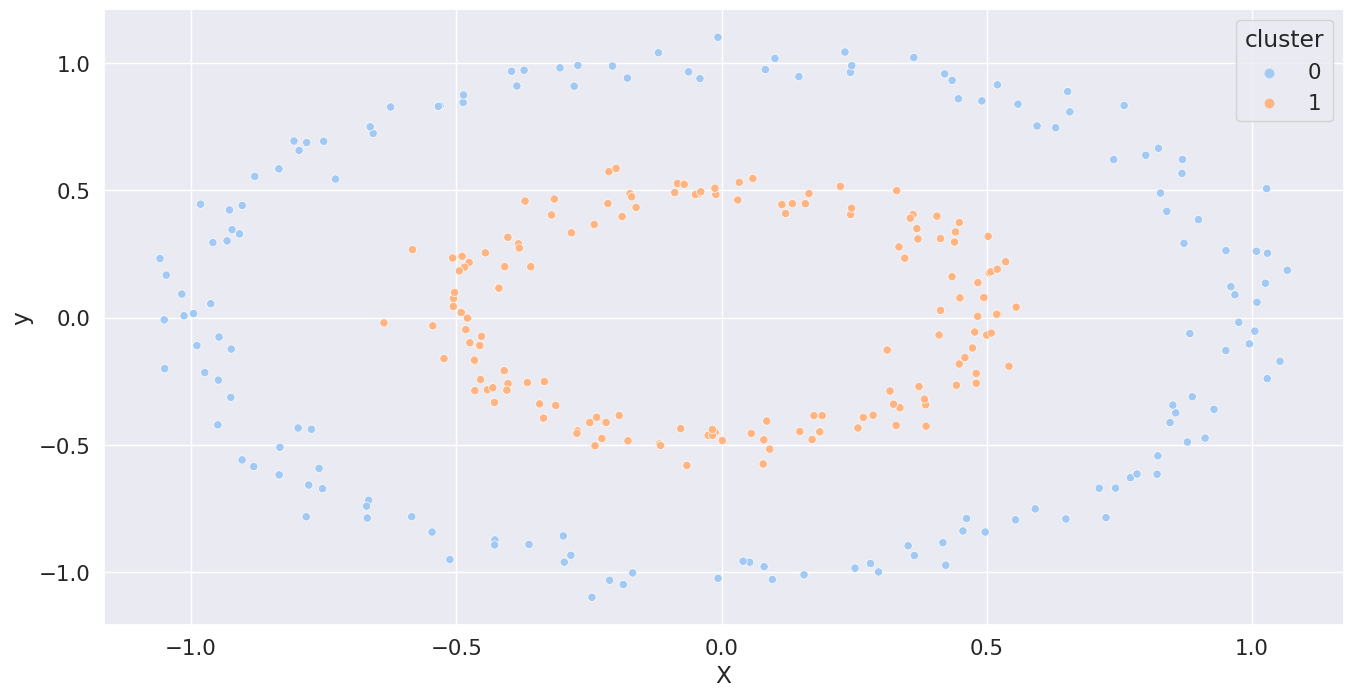

In [39]:
y_pred4_DBSCAN = new_data4['cluster']

fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(data=new_data4, x='X', y='y', hue='cluster', palette='pastel', ax=ax)
plt.show()

# **10.Cluster validation**

>## F-measures

In [40]:
# Calculate the F-measure for KMeans
K_D1_f1=f1_score(y_true1, y_pred1, average='macro')
K_D2_f1=f1_score(y_true2, y_pred2, average='macro')
K_D3_f1=f1_score(y_true3, y_pred3, average='macro')
K_D4_f1=f1_score(y_true4, y_pred4, average='macro')

# Print the result
print("F-measure for KMeans on dataset1: ", K_D1_f1)
print("F-measure for KMeans on dataset2: ", K_D2_f1)
print("F-measure for KMeans on dataset3: ", K_D3_f1)
print("F-measure for KMeans on dataset4: ", K_D4_f1)

F-measure for KMeans on dataset1:  0.0
F-measure for KMeans on dataset2:  0.022973368451858354
F-measure for KMeans on dataset3:  0.753322369883106
F-measure for KMeans on dataset4:  0.506469254368414


In [41]:
# Calculate the F-measure for DBSCAN
DB_D1_f1=f1_score(y_true1, y_pred1_DBSCAN, average='macro')
DB_D2_f1=f1_score(y_true2, y_pred2_DBSCAN, average='macro')
DB_D3_f1=f1_score(y_true3, y_pred3_DBSCAN, average='macro')
DB_D4_f1=f1_score(y_true4, y_pred4_DBSCAN, average='macro')

# Print the result
print("F-measure for DBSCAN on dataset1: ", DB_D1_f1)
print("F-measure for DBSCAN on dataset2: ", DB_D2_f1)
print("F-measure for DBSCAN on dataset3: ", DB_D3_f1)
print("F-measure for DBSCAN on dataset4: ", DB_D4_f1)

F-measure for DBSCAN on dataset1:  0.0
F-measure for DBSCAN on dataset2:  0.007475124378109453
F-measure for DBSCAN on dataset3:  0.0
F-measure for DBSCAN on dataset4:  1.0


>## Normalized mutual information

In [42]:
# Calculate the NMI for KMeans
K_D1_NMI=normalized_mutual_info_score(y_true1,y_pred1)
K_D2_NMI=normalized_mutual_info_score(y_true2,y_pred2)
K_D3_NMI=normalized_mutual_info_score(y_true3,y_pred3)
K_D4_NMI=normalized_mutual_info_score(y_true4,y_pred4)

# Print the result
print("NMI for KMeans on dataset1: ", K_D1_NMI)
print("NMI for KMeans on dataset2: ", K_D2_NMI)
print("NMI for KMeans on dataset3: ", K_D3_NMI)
print("NMI for KMeans on dataset4: ", K_D4_NMI)

NMI for KMeans on dataset1:  0.6482574413980599
NMI for KMeans on dataset2:  0.892675351968861
NMI for KMeans on dataset3:  0.19410470729151777
NMI for KMeans on dataset4:  0.00012852309553749978


In [43]:
# Calculate the NMI for DBSCAN
DB_D1_NMI=normalized_mutual_info_score(y_true1,y_pred1_DBSCAN)
DB_D2_NMI=normalized_mutual_info_score(y_true2,y_pred2_DBSCAN)
DB_D3_NMI=normalized_mutual_info_score(y_true3,y_pred3_DBSCAN)
DB_D4_NMI=normalized_mutual_info_score(y_true4,y_pred4_DBSCAN)

# Print the result
print("NMI for DBSCAN on dataset1: ", DB_D1_NMI)
print("NMI for DBSCAN on dataset2: ", DB_D2_NMI)
print("NMI for DBSCAN on dataset3: ", DB_D3_NMI)
print("NMI for DBSCAN on dataset4: ", DB_D4_NMI)

NMI for DBSCAN on dataset1:  0.6995909718992465
NMI for DBSCAN on dataset2:  0.9283810857972788
NMI for DBSCAN on dataset3:  0.8852365891118971
NMI for DBSCAN on dataset4:  0.9999999999999974


>## Rand Statistic

In [44]:
# Calculate the Rand Statistic for KMeans
K_D1_R=rand_score(y_true1,y_pred1)
K_D2_R=rand_score(y_true2,y_pred2)
K_D3_R=rand_score(y_true3,y_pred3)
K_D4_R=rand_score(y_true4,y_pred4)

# Print the result
print("Rand statistic for KMeans on dataset1: ", K_D1_R)
print("Rand statistic for KMeans on dataset2: ", K_D2_R)
print("Rand statistic for KMeans on dataset3: ", K_D3_R)
print("Rand statistic for KMeans on dataset4: ", K_D4_R)

Rand statistic for KMeans on dataset1:  0.7220958751393534
Rand statistic for KMeans on dataset2:  0.9651950947603122
Rand statistic for KMeans on dataset3:  0.6271125975473801
Rand statistic for KMeans on dataset4:  0.4984169453734671


In [45]:
# Calculate the Rand Statistic for DBSCAN
DB_D1_R=rand_score(y_true1,y_pred1_DBSCAN)
DB_D2_R=rand_score(y_true2,y_pred2_DBSCAN)
DB_D3_R=rand_score(y_true3,y_pred3_DBSCAN)
DB_D4_R=rand_score(y_true4,y_pred4_DBSCAN)

# Print the result
print("Rand statistic for DBSCAN on dataset1: ", DB_D1_R)
print("Rand statistic for DBSCAN on dataset2: ", DB_D2_R)
print("Rand statistic for DBSCAN on dataset3: ", DB_D3_R)
print("Rand statistic for DBSCAN on dataset4: ", DB_D4_R)

Rand statistic for DBSCAN on dataset1:  0.770546265328874
Rand statistic for DBSCAN on dataset2:  0.9802229654403567
Rand statistic for DBSCAN on dataset3:  0.9705908584169454
Rand statistic for DBSCAN on dataset4:  1.0


# **11.Visualization**

In [46]:
# Summarize the measures values for all algorithms and compare the results
table = [['KMeans_dataset1',K_D1_f1, K_D1_NMI, K_D1_R],
         ['KMeans_dataset2',K_D2_f1, K_D2_NMI, K_D2_R],
         ['KMeans_dataset3',K_D3_f1, K_D3_NMI, K_D3_R],
         ['KMeans_dataset4',K_D4_f1, K_D4_NMI, K_D4_R],
         ['DBSCAN_dataset1',DB_D1_f1, DB_D1_NMI, DB_D1_R],
         ['DBSCAN_dataset2',DB_D2_f1, DB_D2_NMI, DB_D2_R],
         ['DBSCAN_dataset3',DB_D3_f1, DB_D3_NMI, DB_D3_R],
         ['DBSCAN_dataset4',DB_D4_f1, DB_D4_NMI, DB_D4_R]]
df_rank = pd.DataFrame(table, columns=['Models', 'F-measures','NMI','Rand Statistic'])
df_rank.set_index('Models')

,F-measures,NMI,Rand Statistic
Models,,,
KMeans_dataset1,0.000000,0.648257,0.722096
KMeans_dataset2,0.022973,0.892675,0.965195
KMeans_dataset3,0.753322,0.194105,0.627113
KMeans_dataset4,0.506469,0.000129,0.498417
DBSCAN_dataset1,0.000000,0.699591,0.770546
DBSCAN_dataset2,0.007475,0.928381,0.980223
DBSCAN_dataset3,0.000000,0.885237,0.970591
DBSCAN_dataset4,1.000000,1.000000,1.000000


In [47]:
# ranking models 
df_rank = pd.DataFrame(table, columns=['Models','F-measures','NMI','Rand Statistic'])
df_rank['F-measures']=df_rank['F-measures'].rank(ascending=False)
df_rank['NMI']=df_rank['NMI'].rank(ascending=False)
df_rank['Rand Statistic']=df_rank['Rand Statistic'].rank(ascending=False)
df_rank['rank'] = df_rank.mean(axis=1)
df_rank['rank']=df_rank['rank'].rank(ascending=True)
df_rank=df_rank.set_index('Models')
df_rank

,F-measures,NMI,Rand Statistic,rank
Models,,,,
KMeans_dataset1,7.0,6.0,6.0,7.5
KMeans_dataset2,4.0,3.0,4.0,3.0
KMeans_dataset3,2.0,7.0,7.0,5.0
KMeans_dataset4,3.0,8.0,8.0,7.5
DBSCAN_dataset1,7.0,5.0,5.0,6.0
DBSCAN_dataset2,5.0,2.0,2.0,2.0
DBSCAN_dataset3,7.0,4.0,3.0,4.0
DBSCAN_dataset4,1.0,1.0,1.0,1.0
